<a id=top-page></a>
# `pykitPIV` demo: Generate synthetic BOS images

In this Jupyter notebook, we show how `pykitPIV` can be used as a synthetic BOS image generator. This notebook shows the full workflow that uses the four classes in a sequence:

`Particle` $\rightarrow$ `FlowField` $\rightarrow$ `Motion` $\rightarrow$ `Image`

<div class="alert alert-block alert-info" style="margin-top: 20px">
<font size="3"><strong>Table of contents:</strong></font>
<br>
<ol>
    <li><a href="#generate-particles">Generate particles</a></li>
    <li><a href="#generate-velocity-field">Generate random velocity field to advect the particles</a></li>
    <li><a href="#add-movement">Add movement to particles</a></li>
        <ul>
        <li><a href="#add-movement-update-time-sep">Update time separation</a></li>
        <li><a href="#add-movement-visualize">Visualize the PIV image pair</a></li>
        </ul>
    <li><a href="#save">Save the dataset</a></li>
    <li><a href="#upload">Upload the saved datasets</a></li>
</ol>
<p></p>
</div>
<br>

***

In [1]:
import numpy as np
import cmcrameri.cm as cmc
from scipy.ndimage import map_coordinates 
from pykitPIV import Particle, FlowField, Motion, Image

2025-05-06 13:46:14.318543: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [57]:
save_images = False
n_images = 1
image_size = (512, 512)
size_buffer = 0
origin = 'lower'
figsize = (6,6)
filename = None

<a id=generate-particles></a>
***

## Generate particles

[Go to the top](#top-page)

In [58]:
particles = Particle(n_images, 
                     size=image_size, 
                     size_buffer=size_buffer,
                     diameters=10,
                     distances=1,
                     densities=1.2,
                     diameter_std=0,
                     seeding_mode='poisson',
                     random_seed=100)

In [59]:
image = Image(random_seed=100)

In [60]:
image.add_particles(particles)

In [61]:
image.add_reflected_light(exposures=0.99,
                          maximum_intensity=2**16-1,
                          no_laser_plane=True,
                          alpha=1/8,
                          extend_gaussian=2)

In [62]:
image.exposures_per_image

array([0.99])

In [63]:
particles.n_of_particles

[2294]

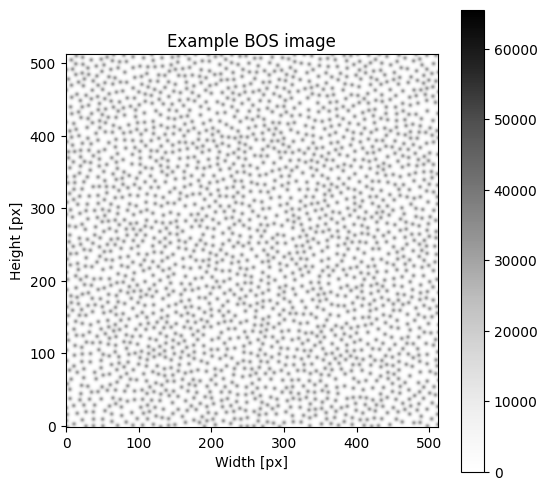

In [64]:
if save_images: filename = 'example-image.png'
plt = image.plot(0,
           with_buffer=True,
           xlabel='Width [px]',
           ylabel='Height [px]',
           title='Example BOS image',
           cmap='Greys',
           origin=origin,
           figsize=figsize,
           filename=filename)

plt.colorbar()

<a id=generate-velocity-field></a>
***

## Generate potential flow field

[Go to the top](#top-page)

In [65]:
flowfield = FlowField(n_images,
                      size=image_size,
                      size_buffer=size_buffer,
                      random_seed=100)

In [66]:
flowfield.generate_potential_velocity_field(imposed_origin=None,
                                            displacement=(2, 2))

In [29]:
flowfield.generate_random_velocity_field(displacement=(0, 10),
                                         gaussian_filters=(10, 30),
                                         n_gaussian_filter_iter=6)

In [12]:
flowfield.generate_sinusoidal_velocity_field(amplitudes=(10,10),
                                             wavelengths=(60,60),
                                             components='u')

In [67]:
image.add_flowfield(flowfield)

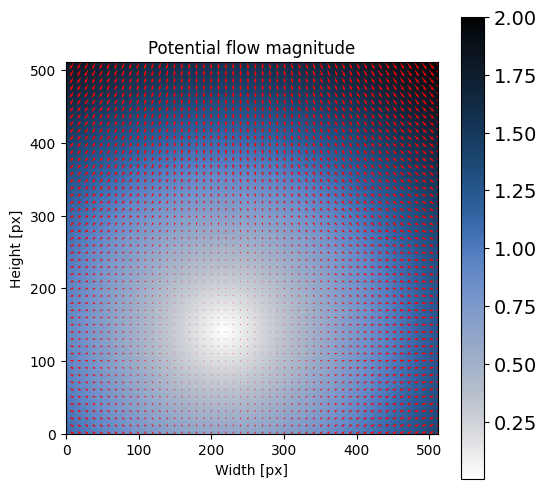

In [68]:
if save_images: filename = 'example-potential-velocity-field-magnitude-quiver.png'
image.plot_field_magnitude(0,
                           with_buffer=False,
                           add_quiver=True,
                           quiver_step=10,
                           quiver_color='r',
                           xlabel='Width [px]',
                           ylabel='Height [px]',
                           title='Potential flow magnitude',
                           cmap=cmc.oslo_r,
                           figsize=figsize,
                           filename=filename);

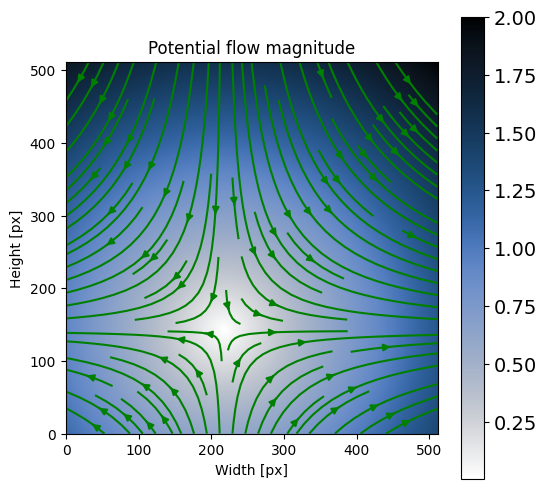

In [69]:
if save_images: filename = 'example-random-velocity-field-magnitude-streamplot.png'
image.plot_field_magnitude(0,
                           with_buffer=False,
                           add_streamplot=True,
                           streamplot_density=1,
                           streamplot_color='g',
                           xlabel='Width [px]',
                           ylabel='Height [px]',
                           title='Potential flow magnitude',
                           cmap=cmc.oslo_r,
                           figsize=figsize,
                           filename=filename);

<a id=add-warping></a>
***

## Add warping to BOS images

[Go to the top](#top-page)

In [140]:
def warp_image(img,
               flow,
               order=1,
               mode='constant'):
    
    H, W = flow.shape[1::]

    yy, xx = np.meshgrid(np.arange(H), np.arange(W), indexing="ij")
    x_src  = xx - flow[0,:]
    y_src  = yy - flow[1,:]

    coords = np.zeros((2, H, W))
    coords[0,:,:] = y_src
    coords[1,:,:] = x_src

    warped = map_coordinates(img, 
                             coords, 
                             order=order,
                             mode=mode).reshape(H, W)

    return warped

In [141]:
img = image.images_I1[0,0,:,:]

In [142]:
flow = np.zeros((flowfield.velocity_field.shape[-2], flowfield.velocity_field.shape[-1], 2))

In [143]:
flow[:,:,0] = flowfield.velocity_field[0,0,:,:]
flow[:,:,1] = flowfield.velocity_field[0,1,:,:]

In [144]:
warped = warp_image(img, flowfield.velocity_field[0,:,:,:]*5)

(512, 512)


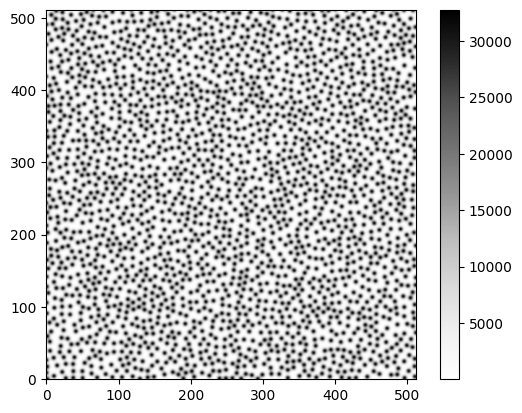

In [145]:
plt.imshow(image.images_I1[0,0,:,:], cmap='Greys', origin='lower')
plt.savefig('I1.png')
plt.colorbar()

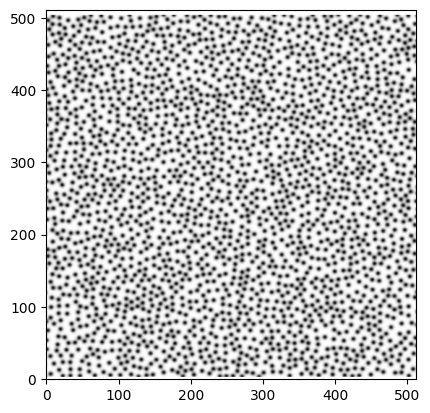

In [146]:
plt.imshow(warped, cmap='Greys', origin='lower')
plt.savefig('I2.png')

***

© K. Zdybał, C. Mucignat, S. Kunz, I. Lunati (2025)